In [130]:
import flexynesis
import flexynesis 
import os
import torch
import numpy as np
import seaborn as sns
torch.set_num_threads(4)

In [ ]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 20 

# Finding Survival Markers in Lower Grade Glioma (LGG) and Glioblastoma Multiforme (GBM)

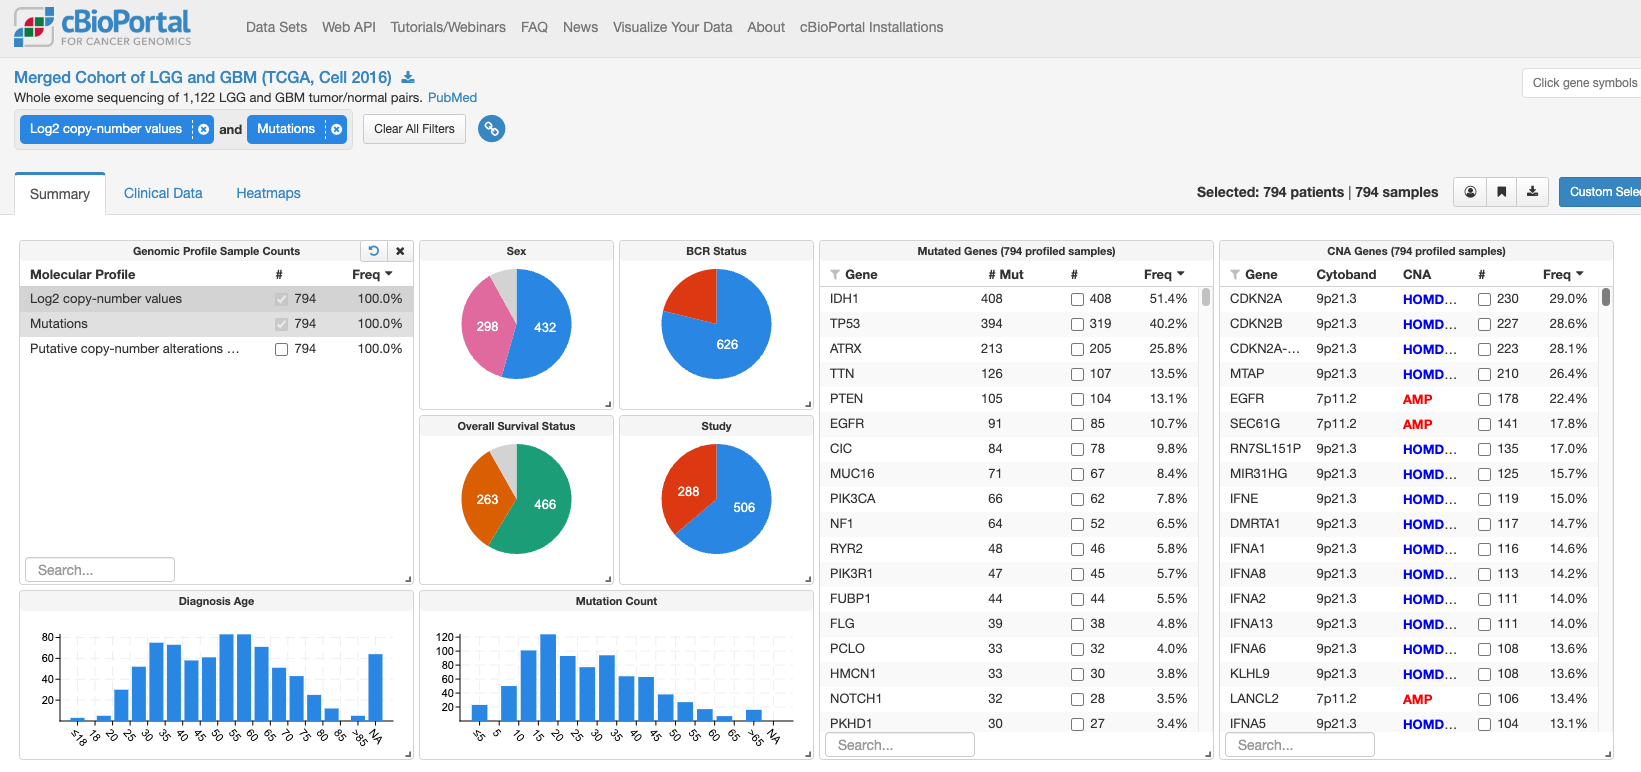

Here, we demonstrate the capabilities of `flexynesis` on a multi-omic dataset of 506 Brain Lower Grade Glioma (LGG) and 288 Glioblastoma Multiforme (GBM) samples with matching mutation and copy number alteration data downloaded from the [cbioportal](https://www.cbioportal.org/study/summary?id=lgggbm_tcga_pub). The data was split into `train` (70% of the samples) and `test` (30% of the samples) data folders. The data files were processed to follow the same nomenclature. 

- `cna.csv` contains "copy number alteration" data
- `mut.csv` contains "mutation" data, which is a binary matrix of genes versus samples. 
- `clin.csv` contains "clinical/sample metatada", which is a table of clinical parameters such as age, sex, disease type, histological diagnosis, and overall survival time and status. 

## Data Download

The data can be downloaded as follows:

In [131]:
if not os.path.exists("lgggbm_tcga_pub_processed"):
    !wget -O lgggbm_tcga_pub_processed.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz" && tar -xzvf lgggbm_tcga_pub_processed.tgz

## Importing Train and Test Datasets

We import train and test datasets including mutations and copy number alterations. We rank genes by Laplacian Scores and pick top 25% of the genes, while removing highly redundant genes with a correlation score threshold of 0.8. By setting `concatenate` to `False`, we will be doing an `intermediate` fusion of omic layers. 

In [132]:
data_importer = flexynesis.DataImporter(path ='lgggbm_tcga_pub_processed', 
                                        data_types = ['mut', 'cna'], log_transform=False, 
                                        concatenate=False, top_percentile=25, min_features=1000, correlation_threshold=0.8)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/train/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/clin.csv...
[INFO] Importing lgggbm_tcga_pub_processed/train/mut.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing lgggbm_tcga_pub_processed/test/cna.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/clin.csv...
[INFO] Importing lgggbm_tcga_pub_processed/test/mut.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 1838 features.
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 0 features.
[INF


Calculating Laplacian scores: 100%|██████████| 9226/9226 [00:00<00:00, 10864.23it/s]

Filtering redundant features: 100%|██████████| 2306/2306 [00:01<00:00, 2002.18it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  24746 features



Calculating Laplacian scores: 100%|██████████| 24746/24746 [00:02<00:00, 11368.52it/s]

Filtering redundant features: 100%|██████████| 6186/6186 [00:00<00:00, 53361.83it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5627 features.
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 0 features.
[INFO] DataFrame mut - Removed 0 samples (0.00%).
[INFO] DataFrame cna - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: mut': 694, 'feature_count in: cna': 6186, 'sample_count': 556}
[INFO] Test Data Stats:  {'feature_count in: mut': 694, 'feature_count in: cna': 6186, 'sample_count': 238}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


## Finding the best model with Bayesian Hyperparameter Optimisation

Now, we are ready to do a model training using hyperparameter optimisation. 
- `model_class`: We pick `DirectPred` (a fully connected network). We could also pick `supervised_vae` (Supervised Variational Auto-encoder with MMD loss), or `MultiTripletNetwork` (a fully connected network with `triplet loss`). 
- `config_name`: We use the default/built-in hyperparameter search space for `DirectPred` class. 
- `surv_event_var` and `surv_time_var`. Survival status (consists of 0s and 1s) and time since last followup. It is important that the `clin.csv` file contains both `OS_MONTHS` and `OS_STATUS` as numerical values.
- `target_variables`: We can concurrently train the same network to be able to predict other variables such as histological diagnosis, howevever, here we just focus on the survival endpoints, so we pass an empty list.
- `n_iter`: We do 20 iterations of hyperparameter optimisation. This is a reasonable number of demonstration purposes, but it could be beneficial to increase this value in order to discover even better models. 
- `plot_losses`: We want to visualize how the training progresses. 
- `early_stop_patience`: If a training does not show any signs of improving the performance on the `validation` part of the `train_dataset` for at least 10 epochs, we stop the training. This not only significantly decreases the amount spent on training by avoiding unnecessary continuation of unpromising training runs, but also helps avoid over-fitting the network on the training data. 

### Define a tuner

In [133]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "supervised_vae",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = [], 
                                        n_iter=HPO_ITER, 
                                        plot_losses=True, 
                                        early_stop_patience=10)

### Perform Training 

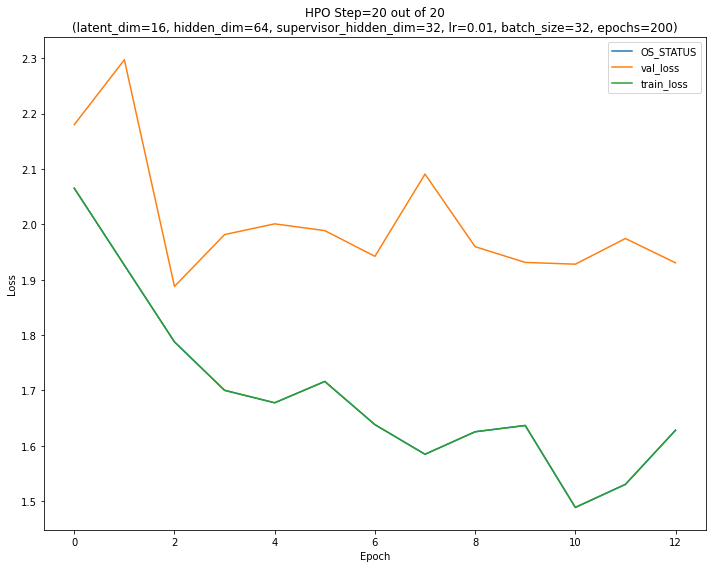

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.888. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_STATUS         │    1.9305272352127802     │
│         val_loss          │    1.9305272352127802     │
└───────────────────────────┴───────────────────────────┘


Tuning Progress: 100%|██████████| 20/20 [03:55<00:00, 11.79s/it, Iteration=20, Best Loss=1.89]


{'latent_dim': 16,
 'hidden_dim': 64,
 'supervisor_hidden_dim': 32,
 'lr': 0.01,
 'batch_size': 32,
 'epochs': 200}

In [134]:
model, best_params = tuner.perform_tuning()
best_params

## Evaluating the model and visualising the results

In [135]:
flexynesis.evaluate_wrapper(y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,var,variable_type,metric,value
0,OS_STATUS,numerical,cindex,0.730605


With a quick HPO routine, we achieve a reasonable performance of Harrell's Concordance Index (C-index) of 0.74 on test data. 

### Survival-risk subtypes 

Let's group the samples by predicted survival risk scores into 3 groups and visualize the sample embeddings colored by risk subtypes. 

In [136]:
# get model outputs for survival variable
outputs = model.predict(test_dataset)['OS_STATUS'].flatten() 
risk_scores = np.exp(outputs)
# Define quantile thresholds
quantiles = np.quantile(risk_scores, [0.5])
# Assign groups based on quantiles
groups = np.digitize(risk_scores, quantiles)

In [137]:
# Extract sample embeddings 
E = model.transform(test_dataset)

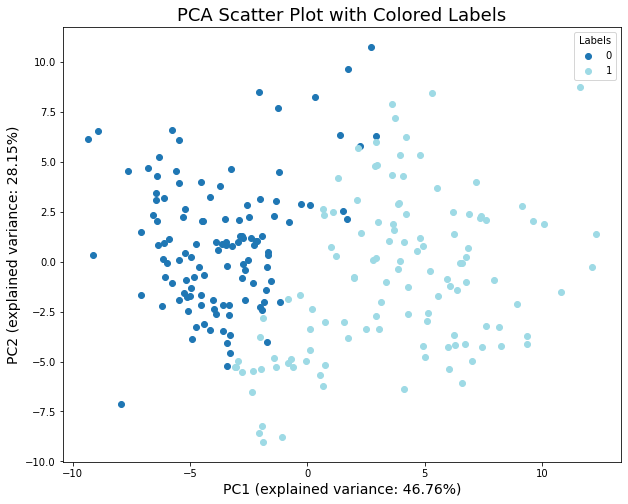

In [138]:
flexynesis.plot_dim_reduced(E, groups)

Let's also see the Kaplan Meier Curves of the risk subtypes

In [139]:
# remove samples with NA values first 
durations = test_dataset.ann['OS_MONTHS']
events = test_dataset.ann['OS_STATUS']
valid_indices = ~torch.isnan(durations) & ~torch.isnan(events)

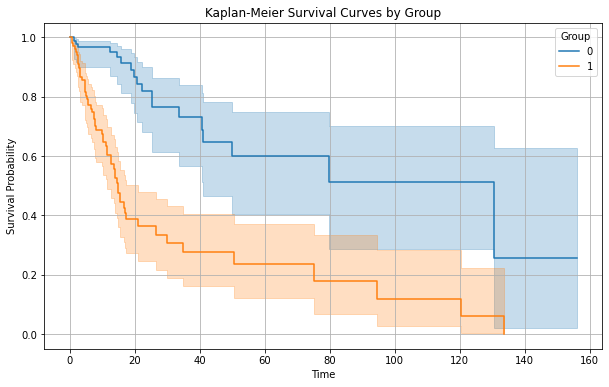

In [140]:
flexynesis.plot_kaplan_meier_curves(durations[valid_indices], events[valid_indices], groups[valid_indices]) 

### Finding survival-associated markers 

We can also compute feature importance scores for prediction of overall survival. 

In [141]:
model.compute_feature_importance('OS_STATUS', steps=20)

In [142]:
# get top 10 features 
flexynesis.get_important_features(model, var = 'OS_STATUS', top=10)

,target_variable,target_class,layer,name,importance
0,OS_STATUS,0,mut,IDH1,0.574344
1,OS_STATUS,0,mut,TP53,0.370100
2,OS_STATUS,0,mut,ATRX,0.288924
3,OS_STATUS,0,mut,PIK3CA,0.121787
4,OS_STATUS,0,mut,IDH2,0.097316
5,OS_STATUS,0,mut,HIVEP3,0.051196
6,OS_STATUS,0,mut,SVIL,0.042847
7,OS_STATUS,0,mut,COL6A3,0.041613
8,OS_STATUS,0,mut,EGFR,0.032933
9,OS_STATUS,0,mut,CIC,0.028073


We find IDH1, TP53, and ATRX as top 3 markers, which are extensively studied and been shown to be relevant in gliomas ([Koschmann et al, 2016](https://www.science.org/doi/full/10.1126/scitranslmed.aac8228)).